necessary imports

In [4]:
## Visualization, sampling and data loading
import squarify 
import os
import PIL
import math
import cv2
import random
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm

## Data modeling
import tensorflow as tf
from keras import Sequential
from sklearn.model_selection import cross_val_score
from keras import backend as K
from tensorflow import keras as keras
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score,  roc_curve, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.layers import Layer, Input, Dense,Dropout, Conv2D, BatchNormalization, Flatten, Input, Conv2D, GaussianNoise,MaxPooling2D, Flatten, Dense, Dropout

### Model evaluatoin
from torchmetrics import Precision, Recall, Accuracy, AUROC
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.metrics')

import numpy as np
from scipy.optimize import brentq
from scipy.interpolate import interp1d

Analisis Kumpulan Data
Ini adalah bagian pertama dari impelementation, yang berisi seluruh proses analisis data. Dimulai dengan membaca data, mengeksplorasi data, melakukan preprocessing data (termasuk gambar dan label) lalu akhirnya mempersiapkannya untuk pelatihan (termasuk membagi menjadi train dan test). Juga akan bereksperimen dengan penambahan data.

In [5]:
def load_dataset(path):
    """
    Loading the dataset into a pandas datframe.
    The images of CASIA-Iris-Thousand are stored as:    /CASIA-Iris-Thousand/YYY/E/S5YYYENN.jpg

        YYY: the unique identifier of the subject in the subset
        E: ‘L’ denotes left eye and ‘R’ denotes right eye
        NN: the index of the image in the class
    
    Args:
        path(str): string that has the path of the dataset
    Returns:
        df(pd.DataFrame): the loaded dataframe
    """
    labels = []
    images = []

    for folder in os.listdir(path):
        for lr in os.listdir(path+'/'+folder): #left or right
            for image in os.listdir(path+'/'+folder+'/'+lr):
                if image.endswith('b') is False:
                    images.append(path+'/'+folder+'/'+lr+'/'+image)
                    labels.append(folder+'-'+lr) #+'-'+lr

    df = pd.DataFrame(list(zip(labels, images)), columns=['Label', 'ImagePath'])
    return df, labels, images

In [6]:
df, labels, images = load_dataset('D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Thousand/')

Mengekspolrasi Dataset
Bagian ini termasuk melihat visulisasi, distribusi, memeriksa nilai yang hilang dan duplikat.

In [7]:
def missing_values(df):
    """
    This is to get the percetages of missing data
    Args:
        df (pd.Dataframe): contains the data
    Returns:
        missing_percetanges(pd.Dataframe): contains Column,	Counts, and	Percentage
            of the missing values for eah colmn
    """
    missing_count = df.isnull().sum()
    missing_percetanges = pd.DataFrame({
        'Column': missing_count.index,
        'Counts': missing_count.values,
        'Percentage': (missing_count.values / len(df)) * 100  
    })
    return  missing_percetanges

In [8]:
def explore_data(df):
    """
    Exploring a dataset sample
    Args:
        sample (pd.Dataframe): the dataset sample to explore.
    Returns:
        results (dict): containing results of each exploration with the title as key
    """
    head = pd.DataFrame(df.head())
    tail = pd.DataFrame(df.tail())
    nunique = pd.DataFrame(df.nunique(), columns=["#_of_Unique"])
    describe = pd.DataFrame(df.describe())
    dtypes =  pd.DataFrame(df.dtypes, columns=["Datatype"])
    labels_distribution = pd.DataFrame(df['Label'].value_counts())
    results = {
        'Table 2: Dataset Head:':head,
        'Table 3: Dataset Tail:':tail,
        'Table 4: Dataset Numerical Describtion: ':describe,
        'Table 5: Missing Values By Percentage': missing_values(df), 
        'Table 6: Dataset Columns Data types: ':dtypes,
        'Table 7: Number of uniques in the datasets:':nunique,
        'Table 8: Labels Distribution:':labels_distribution}
    return results

In [9]:
def print_dataset_exploration(results):
    """
    Prints a beautufil display of each of the exploration dataframe
    Args:
        results (dict): contains exploration outputs with the title as key
    Returns:
        nothing
    """
    for operation, dataframe in results.items():
        print(f"{operation}")
        if operation == 'Table 6: Missing Values By Percentage':
            print("Total Sum of Missing Percetange: ", dataframe['Percentage'].sum())
        display(dataframe)

In [10]:
print_dataset_exploration(explore_data(df))

Table 2: Dataset Head:


,Label,ImagePath
0,000-L,D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Th...
1,000-L,D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Th...
2,000-L,D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Th...
3,000-L,D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Th...
4,000-L,D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Th...


Table 3: Dataset Tail:


,Label,ImagePath
415,020-R,D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Th...
416,020-R,D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Th...
417,020-R,D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Th...
418,020-R,D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Th...
419,020-R,D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Th...


Table 4: Dataset Numerical Describtion: 


,Label,ImagePath
count,420,420
unique,42,420
top,000-L,D:/Christian/Telkom/SEM6/SKC/nwe/CASIA-Iris-Th...
freq,10,1


Table 5: Missing Values By Percentage


,Column,Counts,Percentage
0,Label,0,0.0
1,ImagePath,0,0.0


Table 6: Dataset Columns Data types: 


,Datatype
Label,object
ImagePath,object


Table 7: Number of uniques in the datasets:


,#_of_Unique
Label,42
ImagePath,420


Table 8: Labels Distribution:


,count
Label,
000-L,10
015-R,10
011-R,10
012-L,10
012-R,10
013-L,10
013-R,10
014-L,10
014-R,10


In [ ]:
Visualisasi Data

In [11]:
def show_random_samples(df, num):
    """
    Shows a sample on the dataframe in a specific location.
    Args:
        df (pd.DataFrame): the dataset
        num (int): the number of random samples to display
    Return:
        Nothing but shows a sample in the display
    """
    random.seed(1190652)
    random_indices = random.sample(range(df.shape[0]), num)
    num_rows = math.ceil(num / 4) 

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5))  
    for i, idx in enumerate(random_indices):
        row = i // 4
        col = i % 4
        
        if idx < df.shape[0]:  
            image_path =  df.loc[idx, "ImagePath"]
            image = PIL.Image.open(image_path)
            ax = axes[row, col] if num_rows > 1 else axes[col]
            ax.imshow(image, cmap='gray')
            ax.set_title(f"Image {idx} Person Label: {df.loc[idx, 'Label']}")
            ax.axis("off")

    plt.suptitle("Figure 3: Random Small Sample of the Dataset")
    plt.tight_layout()
    plt.show()

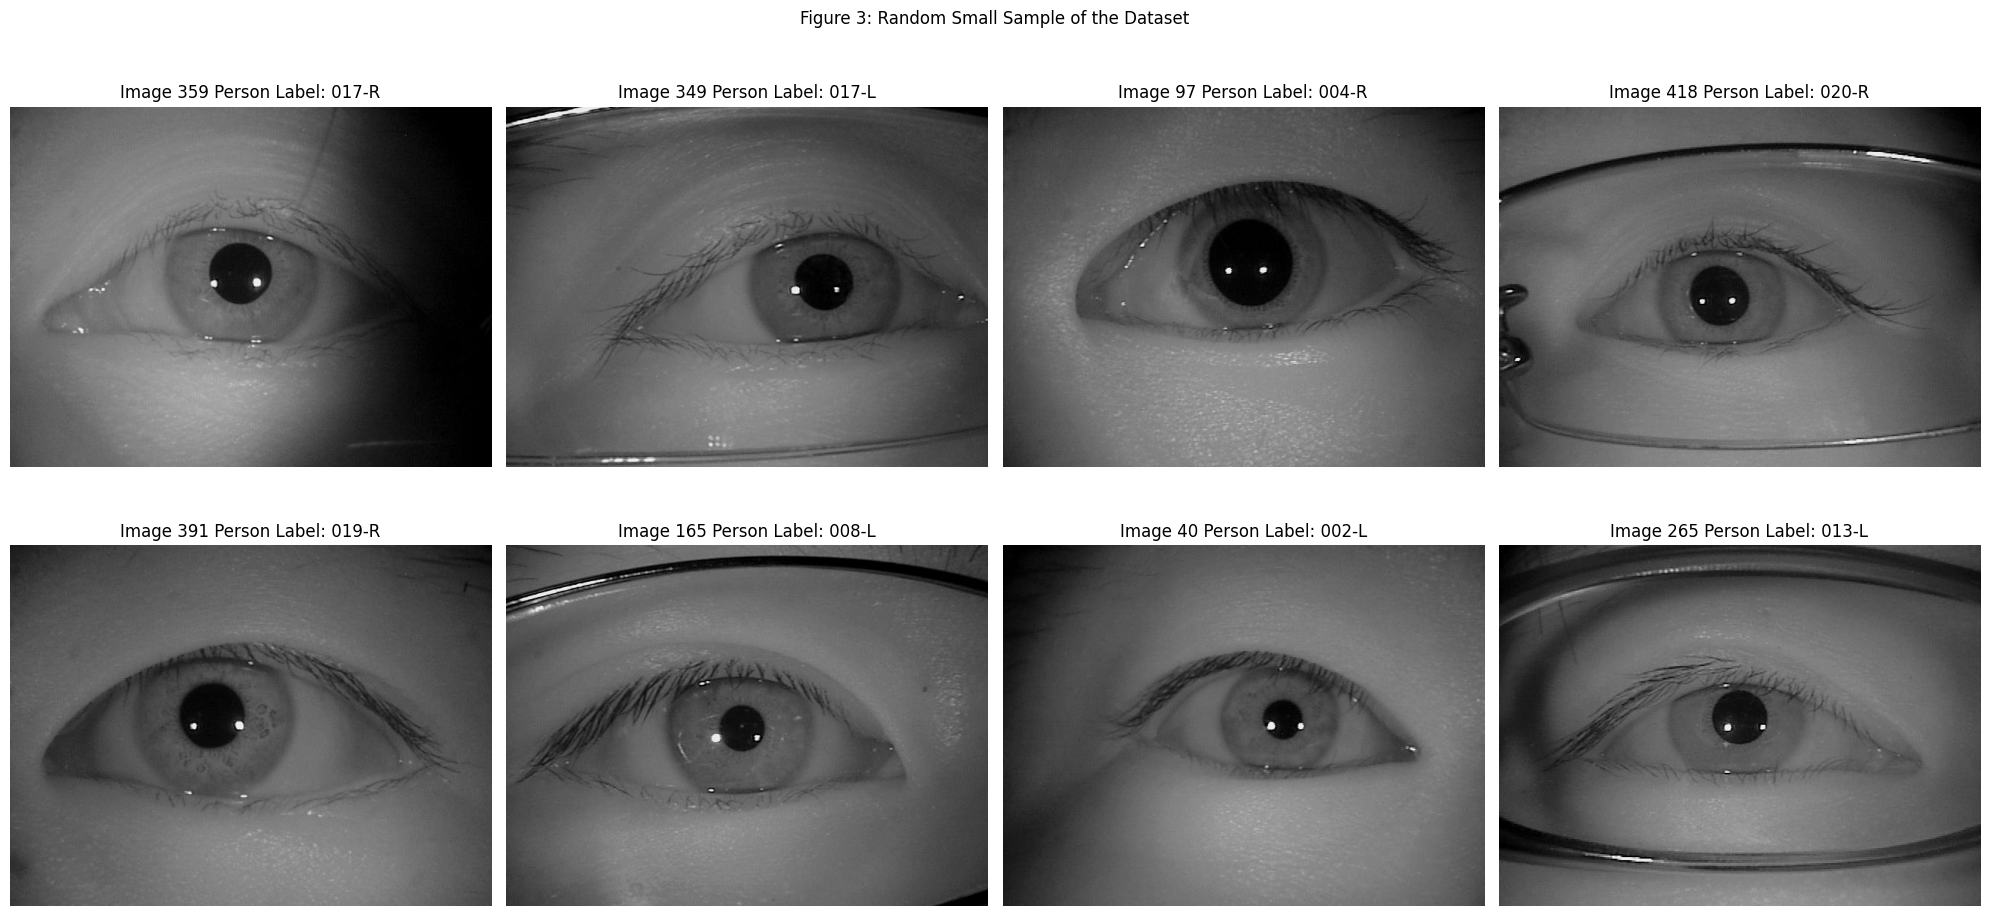

In [12]:
show_random_samples(df, 8)

Terlihat bahwa gambar acak ini mengandung fitur yang berbeda dari subjek yang ada di dalamnya:

Sebagian mata adalah sampel kiri dan sebagian mata adalah sampel kanan.
Beberapa mata memiliki kacamata.
Beberapa mata menggunakan eyeliner.
Beberapa interval mata besar.
Beberapa interval mata kecil.
Gambar berskala abu-abu.

The width of the images:  640
The height of the images:  480
Shape (640, 480)


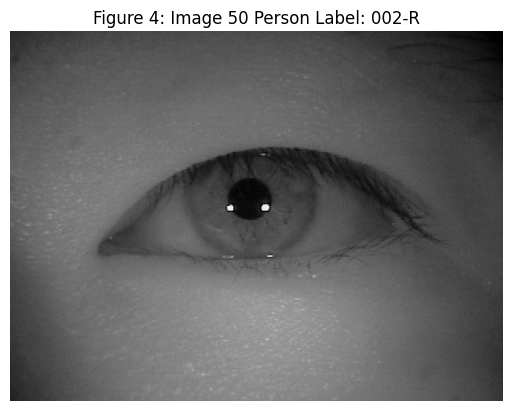

In [13]:
image_path =  df.loc[50, "ImagePath"]
image = PIL.Image.open(image_path)
plt.imshow(image, cmap='gray')
plt.title(f"Figure 4: Image {50} Person Label: {df.loc[50, 'Label']}")
plt.axis("off")
width, height = image.size
print("The width of the images: ", width)
print("The height of the images: ", height)
print("Shape", image.size)

Distribusi Data

In [14]:
image_sizes = []
aspect_ratios = []

for image_path in df['ImagePath']:
    image = PIL.Image.open(image_path)
    width, height = image.size
    image_sizes.append(width * height)
    aspect_ratios.append(width / height)

Text(0, 0.5, 'Frequency')

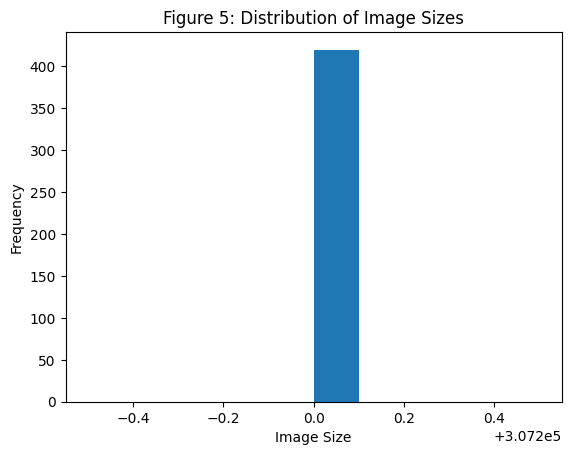

In [15]:
plt.hist(image_sizes, label="Image Size")
plt.title("Figure 5: Distribution of Image Sizes")
plt.xlabel("Image Size")
plt.ylabel("Frequency")

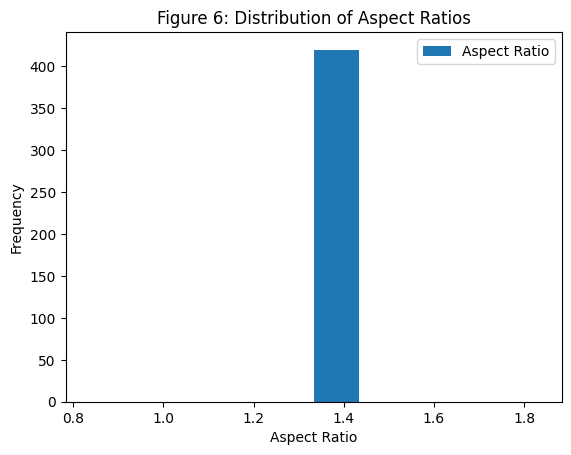

In [16]:
plt.hist(aspect_ratios, label="Aspect Ratio")
plt.title("Figure 6: Distribution of Aspect Ratios")
plt.xlabel("Aspect Ratio")
plt.ylabel("Frequency")
plt.legend()

Mempersiapkan Dataset
Termasuk pemotongan ke dalam pelatihan, pengujian dan validasi, pemrosesan awal gambar ke ukuran yang sesuai, pengkodean label.

Mempersiapkan gambar
Dalam eksplorasi dataset, tidak ada gambar yang hilang, dan semua gambar memiliki ukuran yang sama dan rasio aspek yang sama. Namun, karena keterbatasan sumber daya pemrosesan, keputusan yang diambil adalah mengubah ukuran semua gambar menjadi ukuran yang konsisten tetapi lebih kecil dari ukuran sekarang. Algoritma pengubahan ukuran bebas distorsi, ukurannya diubah tetapi rasio aspeknya sama dengan menggunakan nilai pading.

In [40]:
# Dataset Config
SIZE = 420
NUM_CLASSES = 2000
IMG_HEIGHT = 150
IMG_WIDTH = 150
NUM_CHANNELS = 1
input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

In [41]:
def resize_keep_aspect_ration(img, target_height=IMG_HEIGHT, target_width=IMG_WIDTH, pad_value=255):
    """
    Resize an image to a specific size keeping the aspect ratio using padding
    Args:
        - img (np.array): image
        - target_height (int): with the deafult value as IMG_HEIGHT
        - target_width (int): with the deafult value as IMG_WIDTH
        - pad_value (int): the padding value foe the left of the image with the deafult value is 255
    Returns:
        - The resized image
    """
    aspect_ratio = img.shape[1] / img.shape[0]
    
    ## Get the new sizes with keeping the aspect ratio
    if aspect_ratio > target_width / target_height:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    resized_img = cv2.resize(img, (new_width, new_height))
    
    ## Padding up and down so the image is in the middle
    preprocessed_img = np.full((target_height, target_width), pad_value, dtype=np.uint8)
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    preprocessed_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_img
    
    return preprocessed_img


Fungsi prapemrosesan gambar akan menyertakan:
Membaca dengan skala abu-abu.
Mengubah ukuran dengan mempertahankan rasio aspcet.
Normalisasi. [0, 1]

In [42]:
def preprocess_image(img_dir):
    """
    Resizing imgaes with keeping the aspect ratio.
    Args:
        img_dir(str): Image path on the dataset
        target_height(int): the targeted height to be resized
        target_width(int): the targeted width to be resized
        pad_value(int): used as the padding value for the resized image
    Returns:
        preprocessed_img (cv.Imgae): processsed image
    """
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    img = resize_keep_aspect_ration(img)
    img = img/255.
    
    return img

<function matplotlib.pyplot.show(close=None, block=None)>

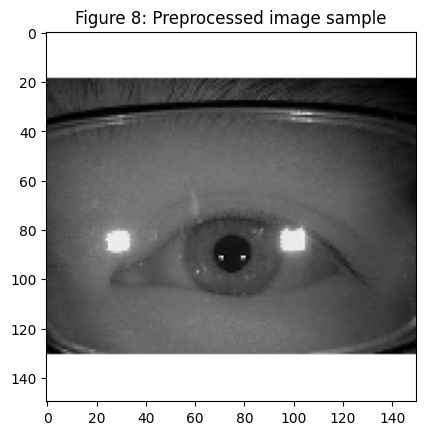

In [43]:
plt.imshow(preprocess_image(df.iloc[15]['ImagePath']), cmap="gray")
plt.title("Figure 8: Preprocessed image sample")
plt.show

persiapan label:
Untuk label yang dipersiapkan untuk pelatihan, tidak banyak yang diperlukan. Tidak ada nilai yang hilang, namun tipe data label akan berupa string, bukan numerik. Label akan dianggap sebagai string (nama orang) dan akan dikodekan. Distribusi label juga diperiksa dan ditemukan bahwa labesl memiliki distribusi yang sama dan tidak ada penambahan data khusus yang diperlukan.

In [44]:
def preprocess_labels(df):
    """
    Prepares labels for training indluding transform to string and then encode.
    Args: 
        df(pd.DataFrame): dataset non-encoded labels and images paths
    Rteurns:
        labels(np.array): prepared labels for training
    """
    labels = df['Label'].astype(str)
    le = LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    return labels

Contoh prapemrosesan label menjadi label yang dikodekan:

In [45]:
print("Label after encoding: ", preprocess_labels(df)[120])
print("Label before encoding: ",df.iloc[120]['Label'])

Label after encoding:  12
Label before encoding:  006-L


Pisahkan dataset menjadi dataset pelatihan, pengujian, dan validasi. Aturan pembagiannya adalah 70:15:15

In [46]:
def split_dataset(preprocessed_images, preprocessed_labels, train_size=0.8, validation_size=0.1, shuffle=True):
    """
    Returns the splitted dataset using the 80:10:10 split rule (for deep learnig we do train split) Pareto principle
    Args:
        preprocessed_images()
        preprocessed_labels
    Returns:
        x_train(np.Array): training images
        x_valid(np.Array): validation images
        x_test(np.Array): testing images
        y_train(np.Array): training labels
        y_valid(np.Array): validation labels
        y_test(np.Array): testing labeles
    """
    np.random.seed(1190652)
    indices = np.arange(SIZE)
    if shuffle:
        np.random.shuffle(indices)
    
    train_samples = int(SIZE * train_size)
    validation_samples = int(SIZE * validation_size)
    
    train_indices = indices[:train_samples]
    validation_indices = indices[train_samples:train_samples + validation_samples]
    test_indices = indices[train_samples + validation_samples:]
    
    x_train  = preprocessed_images[train_indices]
    y_train = preprocessed_labels[train_indices]
    x_valid = preprocessed_images[validation_indices]
    y_valid = preprocessed_labels[validation_indices]
    x_test = preprocessed_images[test_indices]
    y_test = preprocessed_labels[test_indices]
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

Persiapan dataset untuk pelatihan

In [47]:
def prepare_dataset(df):
    """
    Prepares the dataset to training and modeling
    Args:
        df(pd.DataFrame): the dataset
    Returns:
        x_train(np.Array): training images
        x_valid(np.Array): validation images
        x_test(np.Array): testing images
        y_train(np.Array): training labels
        y_valid(np.Array): validation labels
        y_test(np.Array): testing labeles
    """
    preprocessed_images = []
    for i in range(SIZE):
        image = preprocess_image(images[i])
        preprocessed_images.append(image)
    
    preprocessed_images = np.array(preprocessed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
    preprocessed_labels = preprocess_labels(df)
    return split_dataset(preprocessed_images, preprocessed_labels)

In [84]:
x_train, x_valid, x_test, y_train, y_valid, y_test = prepare_dataset(df)
print("Training set size: ", x_train.shape)
print("Testing set size: ",x_test.shape)

Training set size:  (336, 150, 150, 1)
Testing set size:  (42, 150, 150, 1)


Penambahan Data
Berikut ini adalah salah satu eksperimen yang dilakukan, yaitu pelatihan pada gambar yang ditambah. Untuk beberapa alasan, kegagalan memberikan hasil yang lebih baik. Pemikirannya mungkin karena teknik yang digunakan itu sendiri atau karena tugas yang diberikan, bisa jadi membutuhkan sintesis data dan bukan augmentasi data

In [49]:
class CentralCrop(Layer):
    def __init__(self, central_fraction=0.5):
        super(CentralCrop, self).__init__()
        self.central_fraction = central_fraction

    def call(self, inputs):
        cropped = tf.image.central_crop(inputs, central_fraction=self.central_fraction)
        return cropped

In [50]:
data_augmentation = keras.Sequential([
    Input(shape=input_shape),
    CentralCrop(central_fraction=0.5)  
])

augmented_images = data_augmentation(x_train)  

Berikut ini adalah contoh dari dataset yang ditambah

Encoded Person Label is: 14


<function matplotlib.pyplot.show(close=None, block=None)>

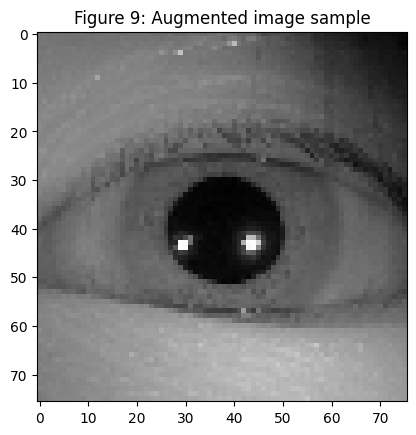

In [55]:
print(f'Encoded Person Label is: {y_valid[10]}')
plt.imshow(augmented_images[40], cmap="gray")
plt.title("Figure 9: Augmented image sample")
plt.show

Pemodelan data (The Verifier)
Pengaturan dan konfigurasi pelatihan, callback: untuk pengaturan pelatihan yang lebih baik, tiga callback digunakan, salah satunya digunakan untuk penghentian awal berdasarkan kehilangan validasi (minimalisasi). Satu menyimpan bobot terbaik model yang disebut model checkpointing dan akhirnya Reduce LR pada Platea yang memonitor kehilangan validasi dan perubahan pada tujuan (minimalisasi)

In [64]:
# Training Config:
EPOCHS = 12
BATCH_SIZE = 10
loss = 'sparse_categorical_crossentropy'
# optimizer = 'adam'
activation = "leaky_relu"
initial_learning_rate = 0.0010000000474974513
optimizer = Adam(learning_rate=initial_learning_rate)

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

Model Archeticticure:

In [65]:
def create_model():
    """
    Create the model architicure and compile it, call on pre-set values.
    Returns:
        model (keras.Sequential): a model compiled with its layers
    """
    padding = 'same'
    poolpadding = 'valid'

    model = Sequential([
        Input(input_shape),
        ####### Features extraction
        
        Conv2D(32, (5, 5), padding=padding, activation=activation, name="Conv1"),
        BatchNormalization(axis=-1, name="BN1"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool1"),
        GaussianNoise(0.1, name="GaussianNoise"), 
        Dropout(0.1, name="Dropout1"),

        Conv2D(64, (5, 5), padding=padding, activation=activation, name="Conv2"),
        BatchNormalization(axis=-1, name="BN2"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool2"),
        Dropout(0.1, name="Dropout2"),

        Conv2D(128, (5, 5), padding=padding, activation=activation, name="Conv3"),
        BatchNormalization(axis=-1, name="BN3"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool3"),
        Dropout(0.25, name="Dropout3"),

        Conv2D(256, (3, 3), padding=padding, activation=activation, name="Conv4"),
        BatchNormalization(axis=-1, name="BN4"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool4"),
        Dropout(0.25, name="Dropout4"),

        Conv2D(256, (3, 3), padding=padding, activation=activation, name="Conv5"),
        BatchNormalization(axis=-1, name="BN5"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool5"),
        Dropout(0.25, name="Dropout5"),
        
        Conv2D(512, (3, 3), padding=padding, activation=activation, name="Conv6"),
        BatchNormalization(axis=-1, name="BN6"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool6"),
        Dropout(0.45, name="Dropout6"),
        
        Conv2D(512, (2, 2), padding=padding, activation=activation, name="Conv7"),
        BatchNormalization(axis=-1, name="BN7"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool7"),
        Dropout(0.5, name="Dropout7"),
        
        #### Flatten and fully connected layers, classifier using relu sofftmax
        Flatten(),
        Dense(128, activation=activation, name = "Dense1"),
        Dense(2000, activation='softmax', name="SoftmaxClasses"),
    ],
    name="IRISRecognizer")
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

Pelatihan dan pengujian model:

In [66]:
model = create_model()
model.summary()

Model: "IRISRecognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 150, 150, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN1 (BatchNormalization)             │ (None, 150, 150, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool1 (MaxPooling2D)                │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GaussianNoise (GaussianNoise)        │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout1 (Dropout)                   │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 75, 75, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN2 (BatchNormalization)             │ (None, 75, 75, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool2 (MaxPooling2D)                │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout2 (Dropout)                   │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 37, 37, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN3 (BatchNormalization)             │ (None, 37, 37, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool3 (MaxPooling2D)                │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout3 (Dropout)                   │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN4 (BatchNormalization)             │ (None, 18, 18, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool4 (MaxPooling2D)                │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout4 (Dropout)                   │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 9, 9, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN5 (BatchNormalization)             │ (None, 9, 9, 256)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool5 (MaxPooling2D)                │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout5 (Dropout)                   │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,702,224 (14.12 MB)

 Trainable params: 3,698,704 (14.11 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [67]:

history = model.fit(np.array(x_train), y_train, validation_data=(np.array(x_valid), y_valid), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 334ms/step - accuracy: 0.0159 - loss: 6.5413 - val_accuracy: 0.0000e+00 - val_loss: 5.3046 - learning_rate: 0.0010
Epoch 2/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 330ms/step - accuracy: 0.0532 - loss: 3.8666 - val_accuracy: 0.0238 - val_loss: 4.3498 - learning_rate: 0.0010
Epoch 3/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.1239 - loss: 3.3817 - val_accuracy: 0.0238 - val_loss: 5.7883 - learning_rate: 0.0010
Epoch 4/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step - accuracy: 0.2482 - loss: 2.6995 - val_accuracy: 0.0238 - val_loss: 8.5848 - learning_rate: 0.0010
Epoch 5/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.3545 - loss: 2.2909 - val_accuracy: 0.0238 - val_loss: 9.5150 - learning_rate: 0.0010
Epoch 6/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.4550 - loss: 2.0915 - val_accuracy: 0.0238 - val_loss: 11.7235 - learning_rate: 0.0010
Epoch 7/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - accuracy: 0.4758 - los

Performa Model (Loss and Accuracy)

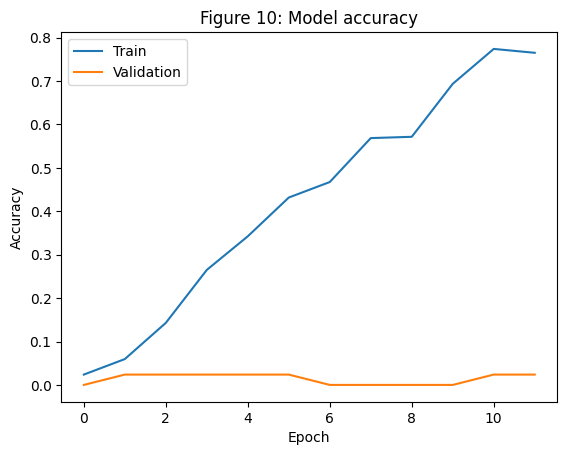

In [68]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Figure 10: Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

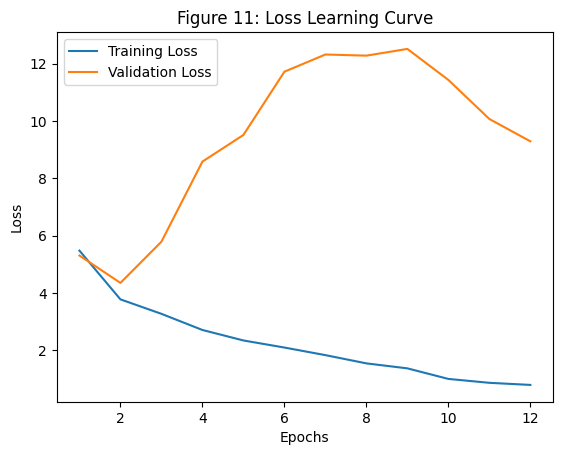

In [69]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Figure 11: Loss Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Testing and save model weights

In [70]:
model.save("IRISRecognizer.h5")
reconstructed_model = keras.models.load_model("IRISRecognizer.h5")
test_loss, test_acc = reconstructed_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.0580 - loss: 7.7765
Test accuracy: 7.143


Prediksi pada gambar sampel

In [71]:
def evaluate_model_visualize(dataset, y_true, model, class_names):
    """
    Make a sample and predict it using the model visualize outputs and calculate the accuracy.
    Args:
        - dataaset (np.array): x_test dataset
        - y_true (np.array): y_test dataset
        - model (keras.Sequential): weighted trained model
        - class_names (pd.Series): classes in the dataset
    Return:
        - Nothing.
    """
    num_rows = 4
    num_cols = 6
    data_batch = dataset[0:num_rows * num_cols]
    predictions = model.predict(data_batch)
    plt.figure(figsize=(20, 8))
    num_matches = 0

    for idx in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(data_batch[idx], cmap="gray")

        pred_idx = np.argmax(predictions[idx])
        true_idx = y_true[idx]

        title = f"{class_names[true_idx]} : {class_names[pred_idx]}"
        title_obj = plt.title(title, fontdict={"fontsize": 13})

        if pred_idx == true_idx:
            num_matches += 1
            plt.setp(title_obj, color="g")
        else:
            plt.setp(title_obj, color="r")
    acc = num_matches / (num_rows * num_cols)
    print("Prediction accuracy: {:.2%}".format(acc))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Prediction accuracy: 0.00%


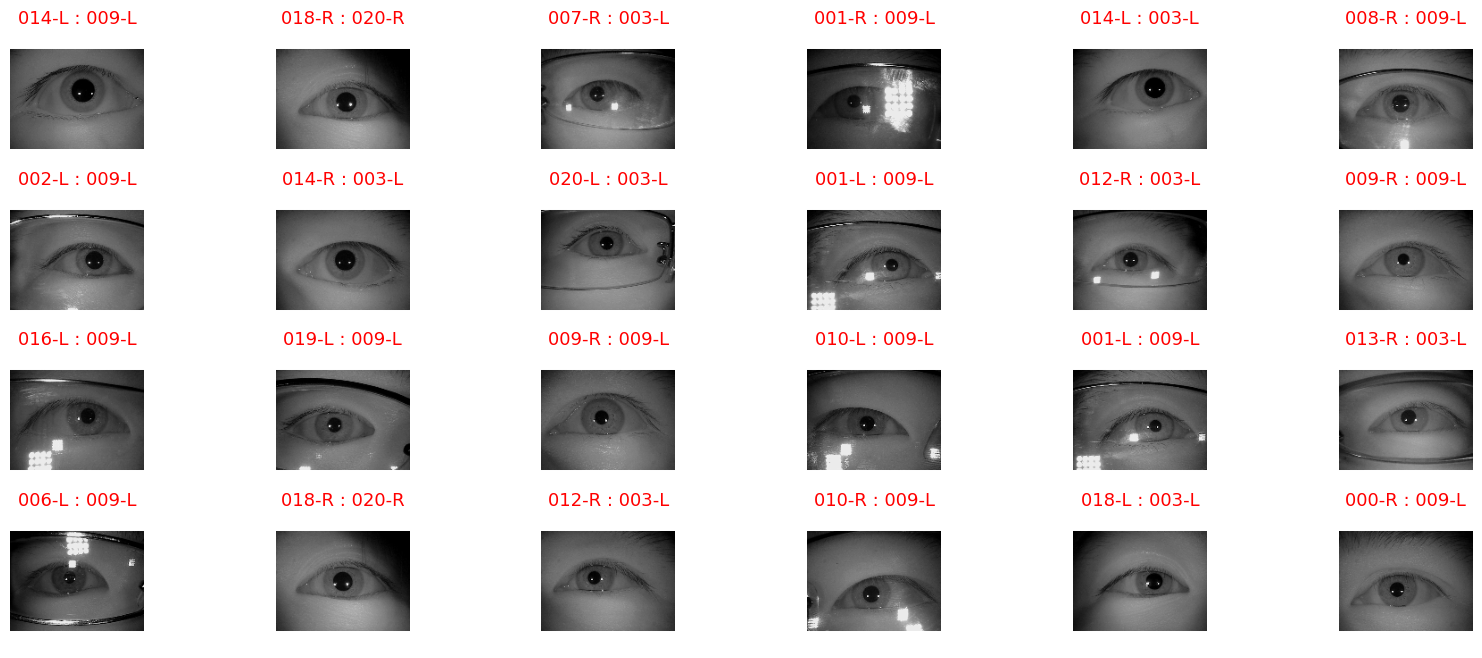

In [72]:
evaluate_model_visualize(x_test,y_test, reconstructed_model,df['Label'].unique())

In [73]:
def describe_model_confedince(reconstructed_model, x_test): 
    """
    This is to look into the distribution of the maximum liklihoods
    represnts the confidence levels of the how much the model is sure this is (the classification)
    Args:
        - reconstructed_model(keras.Sequential): trained weights
        - x_test(np.array): testing images
    Returns:
        Nothing, only prints statics about the max_liklihoods
    """
    probabilites = reconstructed_model.predict(x_test)
    y_pred = np.argmax(probabilites, axis=1)
    max_liklihoods = np.max(probabilites, axis=1)
    print("Average of (Maximum Liklihood) for predictions: ", np.average(max_liklihoods))
    print("Standard deviation of (Maximum Liklihood) for predictions: ", np.std(max_liklihoods))
    print("Median of (Maximum Liklihood) for predictions: ", np.median(max_liklihoods))
    print("Minimum of (Maximum Liklihood) for predictions: ", np.min(max_liklihoods))
    print("Maximum of (Maximum Liklihood) for predictions: ", np.max(max_liklihoods))
    threshold = np.max(max_liklihoods) - np.min(max_liklihoods)
    print("Chosen threshold is: ", threshold)
    return probabilites

In [74]:
probabilites = describe_model_confedince(reconstructed_model, x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Average of (Maximum Liklihood) for predictions:  0.5465228
Standard deviation of (Maximum Liklihood) for predictions:  0.14304583
Median of (Maximum Liklihood) for predictions:  0.5405623
Minimum of (Maximum Liklihood) for predictions:  0.28162032
Maximum of (Maximum Liklihood) for predictions:  0.860803
Chosen threshold is:  0.5791827


Model Evaluaion metrics:
The evaluation is done using the required metrics:

False Match Rate (FMR): The rate at which an imposter is incorrectly classified as a genuine user.
False Non-Match Rate (FNMR): The rate at which a genuine user is incorrectly classified as an imposter.
Plot the Receiver Operating Characteristic (ROC) curve, which shows the trade-off between FMR and FNMR.
Determine the Equal Error Rate (EER), the point on the ROC curve where FMR and FNMR are equal.
MulticlassAccuracy Compute accuracy score, which is the frequency of input matching target.
MulticlassAUPRC Compute AUPRC, also called Average Precision, which is the area under the Precision-Recall Curve, for multiclass classification.
MulticlassAUROC Compute AUROC, which is the area under the ROC Curve, for multiclass classification in a one vs rest fashion.
MulticlassBinnedAUPRC Compute Binned AUPRC, which is the area under the binned version of the Precision Recall Curve, for multiclass classification.
MulticlassBinnedAUROC Compute AUROC, which is the area under the ROC Curve, for multiclass classification.
MulticlassBinnedPrecisionRecallCurve Compute precision recall curve with given thresholds.
MulticlassConfusionMatrix Compute multi-class confusion matrix, a matrix of dimension num_classes x num_classes where each element at position (i,j) is the number of examples with true class i that were predicted to be class j.
MulticlassF1Score Compute f1 score, which is defined as the harmonic mean of precision and recall.
MulticlassPrecision Compute the precision score, the ratio of the true positives and the sum of true positives and false positives.
MulticlassPrecisionRecallCurve Returns precision-recall pairs and their corresponding thresholds for multi-class classification tasks.
MulticlassRecall

In [78]:
precision = Precision(task="multiclass", num_classes=2000)
recall = Recall(task="multiclass", num_classes=2000)
accuracy = Accuracy(task="multiclass", num_classes=2000)
maurc = AUROC(task="multiclass",num_classes=2000)

In [79]:
accuracyv = accuracy(torch.tensor(probabilites), torch.tensor(y_test))
prec = precision(torch.tensor(probabilites), torch.tensor(y_test))
rec = recall(torch.tensor(probabilites), torch.tensor(y_test))
aurc = maurc(torch.tensor(probabilites), torch.tensor(y_test))

C:\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


In [80]:
print(f"Accuracy: {accuracyv}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")

Accuracy: 0.0714285746216774
Precision: 0.0714285746216774
Recall: 0.0714285746216774


In [81]:
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = 2000

for i in range(num_classes):
    y_true_binary = np.where(y_test == i, 1, 0)
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, probabilites[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

C:\Users\chris\AppData\Local\Temp\ipykernel_35252\1224576278.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


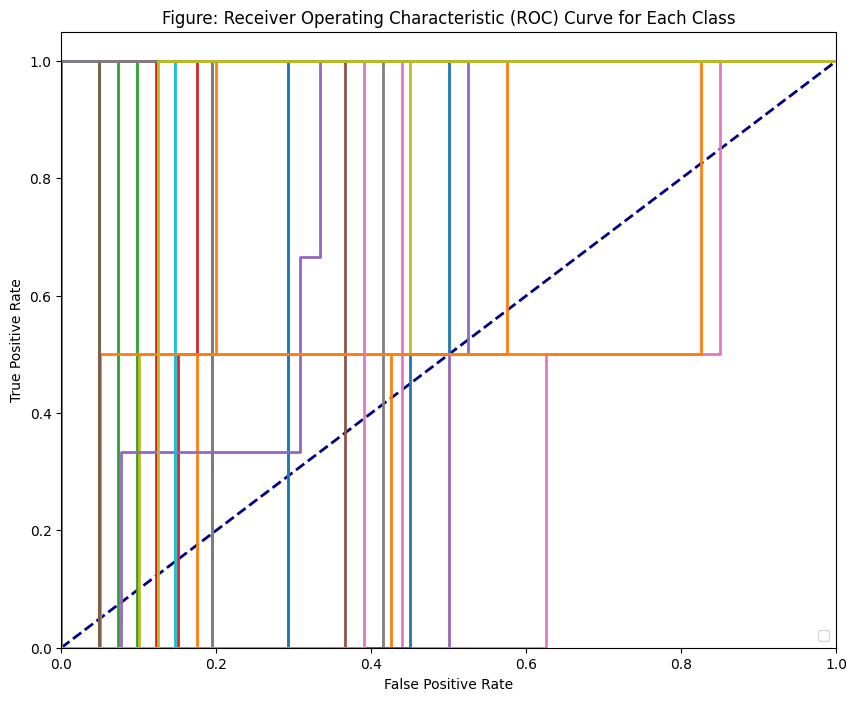

In [82]:
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  ## this is the state of a random classifier

for i in range(num_classes):
    if not math.isnan(roc_auc[i]):
        plt.plot(fpr[i], tpr[i], lw=2)#, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure: Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

In [83]:
eer_thresholds = []

for i in range(num_classes):
    try:
        fpr_values = fpr[i]
        tpr_values = tpr[i]
        interp_fn = interp1d(fpr_values, tpr_values)
        def eer_fn(x):
            return 1.0 - x - interp_fn(x)

        eer_threshold = brentq(eer_fn, 0.0, 1.0)
        eer_thresholds.append(eer_threshold)
    except ValueError:
        continue

avg_eer_threshold = np.mean(eer_thresholds)
print(f"Equal Error Rate (EER) Threshold: {avg_eer_threshold:.4f}")

Equal Error Rate (EER) Threshold: 0.2424
